In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import acf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import mlflow 
import mlflow.pytorch
from datetime import datetime

In [3]:
df = pd.read_csv('../data/ETTm1.csv')

In [4]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [5]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,7.413993,2.261418,4.322226,0.896509,3.082888,0.857907,13.320642
std,7.082928,2.041293,6.829189,1.807239,1.174063,0.600440,8.564817
min,-23.242001,-5.693000,-26.367001,-6.041000,-1.188000,-1.371000,-4.221000
25%,5.827000,0.804000,3.305000,-0.284000,2.315000,0.670000,6.964000
50%,8.841000,2.210000,6.005000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.655000,1.218000,18.079000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69680 entries, 0 to 69679
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69680 non-null  object 
 1   HUFL    69680 non-null  float64
 2   HULL    69680 non-null  float64
 3   MUFL    69680 non-null  float64
 4   MULL    69680 non-null  float64
 5   LUFL    69680 non-null  float64
 6   LULL    69680 non-null  float64
 7   OT      69680 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [7]:
df['date'] = pd.to_datetime(df['date'])

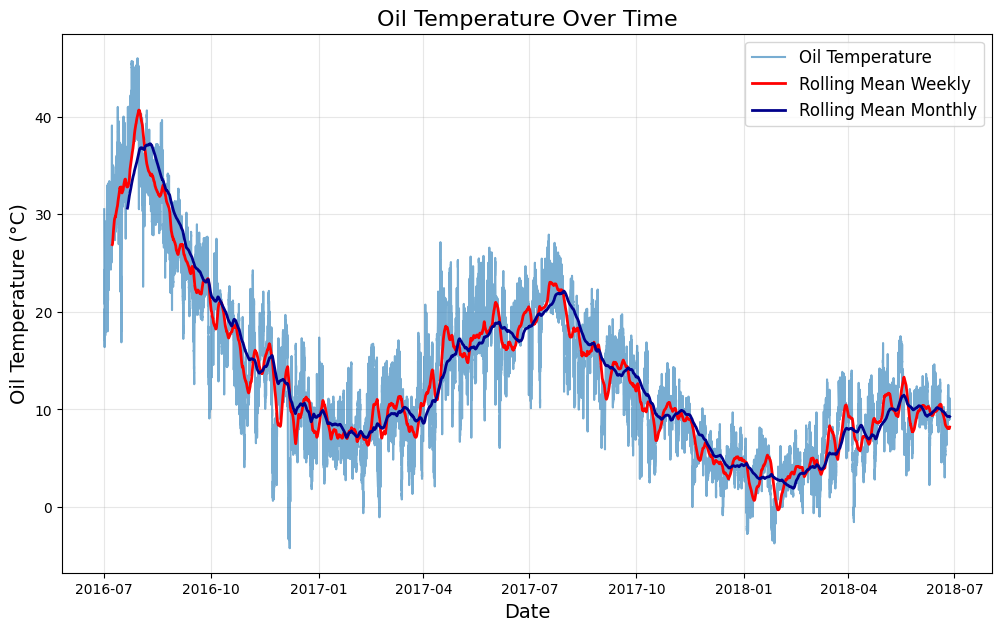

In [8]:
rolling_mean_week = df['OT'].rolling(window=4*24*7).mean() #weekly rolling window
rolling_mean_month = df['OT'].rolling(window=4*24*20).mean()


plt.figure(figsize=(12, 7))

plt.plot(df['date'], df['OT'], label='Oil Temperature', alpha=0.6)
plt.plot(df['date'], rolling_mean_week, label='Rolling Mean Weekly', color='red', linewidth=2)
plt.plot(df['date'], rolling_mean_month, label='Rolling Mean Monthly', color='darkblue', linewidth=2)


plt.title('Oil Temperature Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Oil Temperature (°C)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

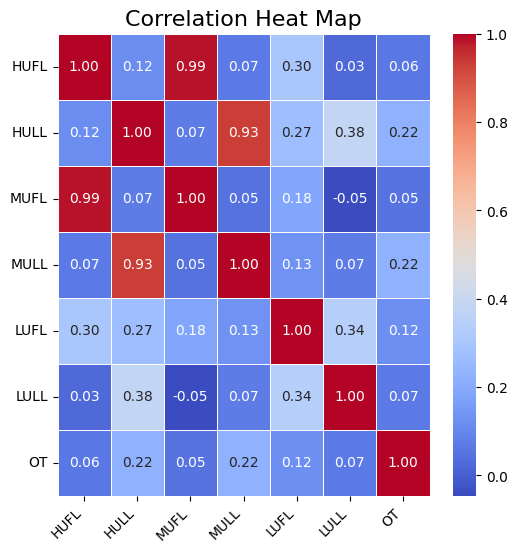

In [14]:
correlations = df.iloc[:,1:].corr()

plt.figure(figsize=(6, 6))  
sns.heatmap(
    correlations, 
    annot=True,        # Annotate cells with the correlation values
    fmt=".2f",         # Format for annotations
    cmap="coolwarm",   # Color map
    linewidths=0.5,    # Add gridlines
    cbar=True          # Show the color bar
)

plt.title("Correlation Heat Map", fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)               
plt.show()

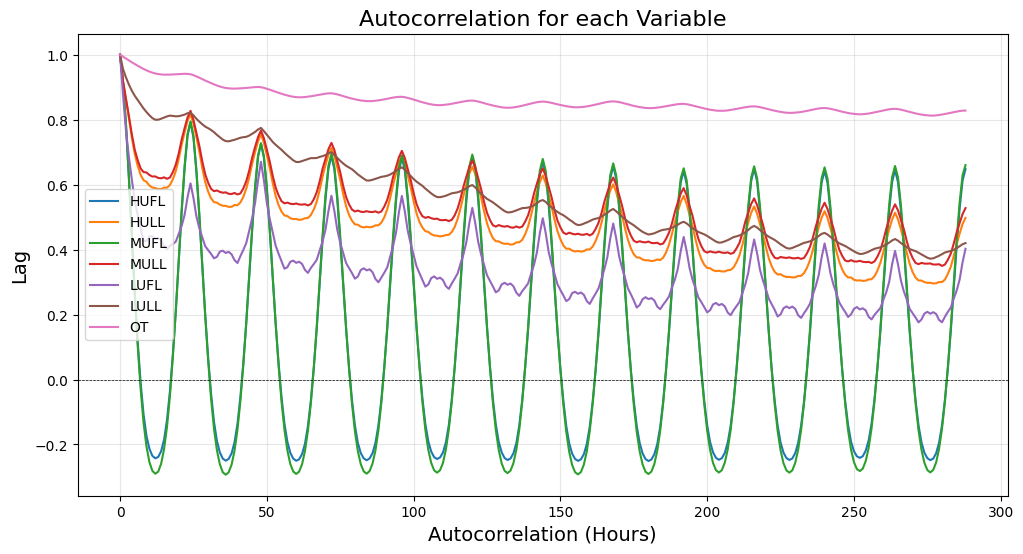

In [64]:
plt.figure(figsize=(12, 6))

for column in df.columns[1:]:
    var = df[column]
    var = var[::4]
    autocorr = acf(var, nlags=24*12)
    plt.plot(range(len(autocorr)), autocorr, label=column)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Autocorrelation (Hours)', fontsize=14)
plt.ylabel('Lag', fontsize=14)
plt.title('Autocorrelation for each Variable', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [ ]:
class ETDataset(Dataset):
    def __init__(self, df, sequence_length=24, targe_column = 'OT'):
        self.sequence_length = sequence_length
        
        feature_cols = df.drop([targe_column, 'date'], axis=1).columns
        self.features = df[feature_cols].values
        self.target = df[targe_column].values

        self.data = []
        self.pred = []

        for i in range(len(self.features) - sequence_length):
            self.data.append(self.features[i:i+sequence_length])
            self.pred.append(self.target[i+sequence_length])

        self.data = np.array(self.data, dtype=np.float32)
        self.pred = np.array(self.pred, dtype=np.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32), torch.tensor(self.pred[index], dtype=torch.float32)

dataset = ETDataset(df)

In [74]:
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate lengths for each subset
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 55724
Testing set size: 13932


In [61]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

    def forward(self, x):
        return x[ -1 ,-1]

baseline_model = BaselineModel()
baseline_model(df.iloc[:1].values)

30.5310001373291

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, num_inputs, hidden_size, num_layers, dropout = 0):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=num_inputs,  hidden_size=hidden_size,num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        _ , hidden = self.rnn(x)
        y = self.linear(hidden[-1])
        return y

In [134]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()

        #define weigths for reset gate
        self.reset_x = nn.Linear(input_size, hidden_size)
        self.reset_h = nn.Linear(hidden_size, hidden_size)

        #define weigths for update gate
        self.update_x = nn.Linear(input_size, hidden_size)
        self.update_h = nn.Linear(hidden_size, hidden_size)

        #define weigts for candidate hidden state
        self.candidate_x = nn.Linear(input_size, hidden_size)
        self.candidate_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        #reset gate
        r = F.sigmoid(self.reset_x(x) + self.reset_h(h))

        #update gate
        z = F.sigmoid(self.update_x(x) + self.update_h(h))

        #candidate hidden state
        h_snake = F.tanh(self.candidate_x(x) + self.candidate_h(r*h))

        h = z*h + (1-z)*h_snake

        return h
    
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()
        self.gru_cell = GRUCell(input_size, hidden_size)
        self.regressor = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        sequence_length = x.shape[1]
        batch_size = x.shape[0]

        # Initialize the hidden state h_0
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the sequence step-by-step
        for t in range(sequence_length):
            x_t = x[:, t, :]  # Input at time step t
            h = self.gru_cell(x_t, h)  # Update hidden state

        # Use the final hidden state to compute the output
        output = self.regressor(h)  # Output shape: (batch_size, 1)
        return output

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [ ]:
def train_model(model, train_loader, test_loader, epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    mlflow.log_param('learning_rate', 1e-4)
    mlflow.log_param('batch_size', 32)
    mlflow.log_param('num_epochs', epochs)

    plot_train_mse = []
    plot_val_mse = []

    current_time = datetime.now().strftime("%H:%M")
    run_name = f"{model.__class__.__name__}_{current_time}"

    with mlflow.start_run(run_name=run_name):
        for epoch in range(epochs):
            running_loss = []
            test_loss = []

            model.train()
            for sequence, pred in train_loader:
                output = model(sequence)

                optimizer.zero_grad()
                loss = criterion(output.squeeze(), pred)
                loss.backward()
                optimizer.step()

                running_loss.append(loss.item())

            model.eval()
            for sequence, pred in test_loader:
                output = model(sequence)

                test_loss.append(criterion(output.squeeze(), pred).item())
            
            plot_train_mse.append(np.mean(running_loss))
            plot_val_mse.append(np.mean(test_loss))

            if (epoch) % 5 == 0:
                print(f'Epoch: {epoch+1} Training MSE: {np.mean(running_loss):.4f} Validation MSE: {np.mean(test_loss):.4f}')
        
    plt.plot(plot_train_mse, label = 'Training MSE')
    plt.plot(plot_val_mse, label = 'Validation MSE')
    plt.tight_layout()
    plt.legend()
    plt.title('Training graph')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(alpha = 0.3)
    plt.show()
    
    return model

Epoch: 1 Training MSE: 111.1202 Validation MSE: 77.7413
Epoch: 2 Training MSE: 72.8523 Validation MSE: 72.3335
Epoch: 3 Training MSE: 69.2148 Validation MSE: 70.3174
Epoch: 4 Training MSE: 67.8487 Validation MSE: 69.1807
Epoch: 5 Training MSE: 66.5152 Validation MSE: 67.4959
Epoch: 6 Training MSE: 64.8185 Validation MSE: 65.8403
Epoch: 7 Training MSE: 63.3062 Validation MSE: 65.1667
Epoch: 8 Training MSE: 61.0847 Validation MSE: 61.9124
Epoch: 9 Training MSE: 58.9275 Validation MSE: 60.0425
Epoch: 10 Training MSE: 56.8708 Validation MSE: 57.6861


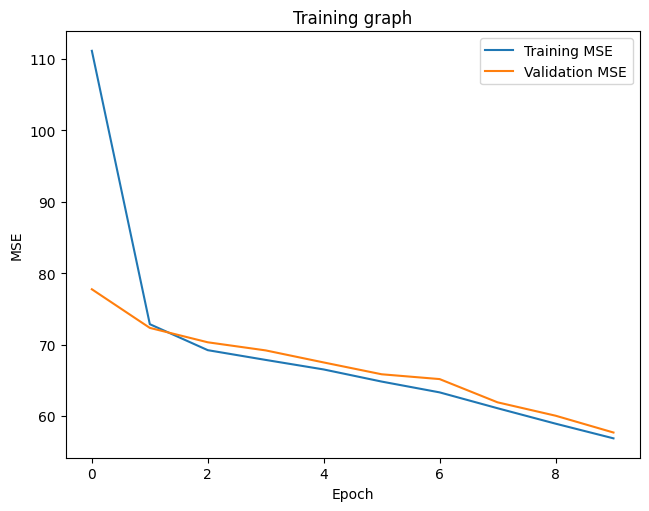

In [131]:
simple_model = SimpleRNN(len(df.columns)-2, 64, 1 )
trained_model = train_model(simple_model, train_loader, test_loader, 10)

Epoch: 1 Training MSE: 166.9703 Validation MSE: 113.9300
Epoch: 2 Training MSE: 89.8352 Validation MSE: 79.4627
Epoch: 3 Training MSE: 74.0141 Validation MSE: 73.1288
Epoch: 4 Training MSE: 69.9675 Validation MSE: 70.7514
Epoch: 5 Training MSE: 68.2728 Validation MSE: 69.4285
Epoch: 6 Training MSE: 67.1426 Validation MSE: 68.4719
Epoch: 7 Training MSE: 66.0488 Validation MSE: 67.4508
Epoch: 8 Training MSE: 64.8885 Validation MSE: 66.1813
Epoch: 9 Training MSE: 63.4672 Validation MSE: 64.4648
Epoch: 10 Training MSE: 61.7196 Validation MSE: 62.5150


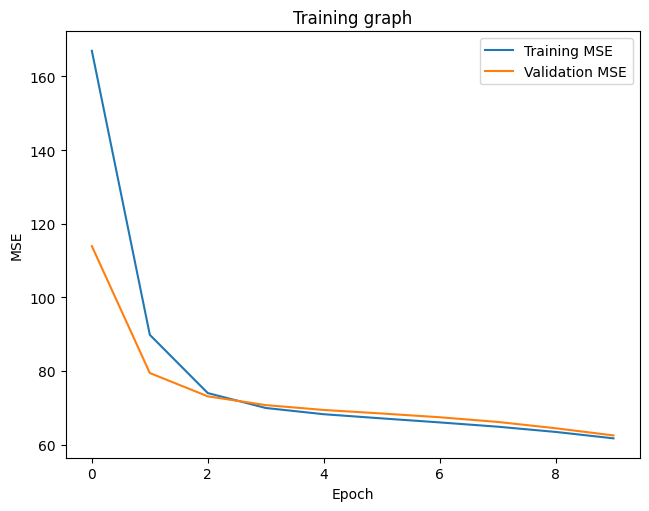

In [140]:
gru_model = GRUModel(6,32)
gru_model_trained = train_model(gru_model, train_loader, test_loader, 10)

In [133]:
inputs, preds = next(iter(train_loader))
trained_model(inputs[:10])
print(inputs[1].shape)

torch.Size([24, 6])
